In [1]:
# Step 1: Load dataset and perform initial checks

import pandas as pd
import numpy as np

# Load dataset (update path if needed)
data = pd.read_csv("week4_BDAT1007_feature_selection_dataset_social_media(in)1.csv")

# Display data types of each column
print("Data Types:\n", data.dtypes)

# Display first five rows
print("\nFirst 5 Rows:\n", data.head())

# Generate summary statistics
print("\nSummary Statistics:\n", data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values in Each Column:\n", missing_values)

# Calculate missing value ratio
missing_ratio = data.isnull().mean()
print("\nMissing Value Ratio:\n", missing_ratio)


Data Types:
 User ID                                         int64
Age                                             int64
Gender                                         object
Country                                        object
Daily Social Media Time (hrs)                 float64
Daily Entertainment Time (hrs)                float64
Social Media Platforms Used                     int64
Primary Platform                               object
Daily Messaging Time (hrs)                    float64
Daily Video Content Time (hrs)                float64
Daily Gaming Time (hrs)                       float64
Occupation                                     object
Marital Status                                 object
Monthly Income (USD)                          float64
Device Type                                    object
Internet Speed (Mbps)                         float64
Subscription Platforms                          int64
Average Sleep Time (hrs)                      float64
Physical Activi

In [3]:
# Step 2: Handling Missing Values Using Missing Value Ratio

# Define threshold for missing value ratio (e.g., 30%)
threshold = 0.30

# Calculate missing value ratio
missing_ratio = data.isnull().mean()

# Drop columns with missing value ratio above threshold
columns_to_drop = missing_ratio[missing_ratio > threshold].index
data_cleaned = data.drop(columns=columns_to_drop)

print(f"Columns dropped due to missing values: {list(columns_to_drop)}")
print("\nUpdated dataset shape:", data_cleaned.shape)

# Check if there are still missing values in the remaining columns
remaining_missing = data_cleaned.isnull().sum()
print("\nRemaining Missing Values:\n", remaining_missing[remaining_missing > 0])

# Impute missing values for numerical columns (if needed)
for col in data_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    data_cleaned[col].fillna(data_cleaned[col].median(), inplace=True)

# Check again for any missing values
print("\nFinal Check - Missing Values After Imputation:\n", data_cleaned.isnull().sum().sum())

Columns dropped due to missing values: []

Updated dataset shape: (300000, 40)

Remaining Missing Values:
 Series([], dtype: int64)

Final Check - Missing Values After Imputation:
 0


In [5]:
# Step 3: Removing Low Variance Features

from sklearn.feature_selection import VarianceThreshold

# Define a variance threshold (e.g., 0.01)
variance_threshold = 0.01

# Selecting only numerical features
numeric_features = data_cleaned.select_dtypes(include=['float64', 'int64'])

# Applying VarianceThreshold
selector = VarianceThreshold(threshold=variance_threshold)
selector.fit(numeric_features)

# Identify columns to keep
columns_to_keep = numeric_features.columns[selector.get_support()]
columns_to_drop = list(set(numeric_features.columns) - set(columns_to_keep))

# Dropping low variance features
data_reduced = data_cleaned.drop(columns=columns_to_drop)

print(f"Columns dropped due to low variance: {columns_to_drop}")
print("\nUpdated dataset shape:", data_reduced.shape)

Columns dropped due to low variance: []

Updated dataset shape: (300000, 40)


In [11]:
# Step 4: Removing Highly Correlated Features 

import numpy as np

# Select only numeric columns for correlation analysis
numeric_data = data_reduced.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_data.corr().abs()

# Define threshold for high correlation
corr_threshold = 0.9

# Identify highly correlated columns
to_drop = []
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if row != col and corr_matrix.loc[row, col] > corr_threshold:
            to_drop.append(col)
            break  # Remove only one of the highly correlated pairs

# Remove duplicate entries in the drop list
to_drop = list(set(to_drop))

# Drop correlated columns from the dataset
data_reduced = data_reduced.drop(columns=to_drop)

print("Columns dropped due to high correlation:", to_drop)
print("Updated dataset shape:", data_reduced.shape)

Columns dropped due to high correlation: []
Updated dataset shape: (300000, 40)


In [15]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Select only numeric columns (for Random Forest)
numeric_data = data_reduced.select_dtypes(include=[np.number]).drop(columns=['User ID'], errors='ignore')

# Define target column
target_column = 'Social Media Fatigue Level (scale 1-10)'

# Separate features and target
X = numeric_data.drop(columns=[target_column])
y = numeric_data[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest model with fewer trees for speed
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Get top features
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
selected_features = feature_importances.nlargest(10).index.tolist()  # Select top 10 features

# Keep only selected features + target column
data_reduced = data_reduced[selected_features + [target_column]]

print("Selected features based on Random Forest:", selected_features)
print("\nUpdated dataset shape:", data_reduced.shape)


Selected features based on Random Forest: ['Monthly Income (USD)', 'Monthly Expenditure on Entertainment (USD)', 'Internet Speed (Mbps)', 'Daily Social Media Time (hrs)', 'Work/Study Time (hrs)', 'Screen Time (hrs)', 'Daily Entertainment Time (hrs)', 'Daily Music Listening Time (hrs)', 'Daily Video Content Time (hrs)', 'Daily Messaging Time (hrs)']

Updated dataset shape: (300000, 11)


In [46]:
#Backward selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data_reduced.drop(columns=[target_column])
y = data_reduced[target_column]

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get absolute coefficient values
feature_importance = abs(model.coef_)

# Select the top N most important features (e.g., top 20)
selected_features = X.columns[np.argsort(feature_importance)[-20:]].tolist()

# Keep only selected features + target
data_reduced = data_reduced[selected_features + [target_column]]

print("Selected features after Backward Selection:", selected_features)
print("\nUpdated dataset shape:", data_reduced.shape)


Selected features after Backward Selection: ['Daily Messaging Time (hrs)', 'Daily Entertainment Time (hrs)', 'Daily Music Listening Time (hrs)', 'Daily Video Content Time (hrs)', 'Daily Social Media Time (hrs)']

Updated dataset shape: (300000, 6)


In [48]:
# Forward Selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data_reduced.drop(columns=[target_column])
y = data_reduced[target_column]

# Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get absolute coefficient values
feature_importance = abs(model.coef_)

# Select the **top 5 most important features** (Forward Selection)
selected_features = X.columns[np.argsort(feature_importance)[-20:]].tolist()

# Keep only selected features + target
data_reduced = data_reduced[selected_features + [target_column]]

print("Selected features after Forward Selection:", selected_features)
print("\nUpdated dataset shape:", data_reduced.shape)


Selected features after Forward Selection: ['Daily Messaging Time (hrs)', 'Daily Entertainment Time (hrs)', 'Daily Music Listening Time (hrs)', 'Daily Video Content Time (hrs)', 'Daily Social Media Time (hrs)']

Updated dataset shape: (300000, 6)


In [21]:
# Save the final reduced dataset to CSV
data_reduced.to_csv("Final_Selected_Features.csv", index=False)

print("Final dataset saved as 'Final_Selected_Features.csv'.")

Final dataset saved as 'Final_Selected_Features.csv'.


In [25]:
import pandas as pd

# Load the saved file
final_data = pd.read_csv("Final_Selected_Features.csv")

# Check if the file is loaded correctly
print(final_data.head())
print("\nFinal dataset shape:", final_data.shape)


   Daily Messaging Time (hrs)  Daily Entertainment Time (hrs)  \
0                        0.35                            4.08   
1                        2.55                            4.21   
2                        2.09                            1.77   
3                        3.69                            9.21   
4                        3.97                            1.30   

   Daily Music Listening Time (hrs)  Daily Video Content Time (hrs)  \
0                              5.31                            5.43   
1                              1.76                            4.22   
2                              2.10                            1.09   
3                              4.16                            4.80   
4                              1.89                            2.74   

   Daily Social Media Time (hrs)  Social Media Fatigue Level (scale 1-10)  
0                           4.35                                        2  
1                           4.

## Explanation of Selected Features  

The goal of this project was to identify the most important factors influencing **Social Media Fatigue Level (scale 1-10)** using feature selection techniques. The dataset contains information about digital habits, screen time, and other behavioral aspects of 300,000 individuals.  

### Why These Features Were Chose (hrs)**  

These features were chosen because they showed the highest importance in predicting social media fatigue.  

1. **Daily Social Media Time (hrs)**: More time spent on social media can lead to increased fatigue, making this an important factor.  
2. **Daily Messaging Time (hrs)**: Frequent messaging could contribute to mental exhaustion, especially if users are constantly engaged in conversations.  
3. **Daily Entertainment Time (hrs)**: High entertainment consumption might reduce fatigue by providing relaxation or increase fatigue if it leads to excessive screen time.  
4. **Daily Music Listening Time (hrs)**: Listening to music could have a positive or negative effect on fatigue levels, depending on usage patterns.  
5. **Daily Video Content Time (hrs)**: Watching videos for long hours might contribute to eye strain and fatigue.  

### Hypothesis and Analysis  
Based on the selected features, we can make some observations:  

- People who **spend more time on social media, messaging, and video content** are more likely to report higher fatigue levels.  
- **Entertainment and music listening time** may have mixed effects depending on the person’s habits.  
- The correlation heatmap shows that the selected features are not highly correlated with each other, meaning each one brings unique information to the prediction model.  

This analysis helps in understanding how different digital habits contribute to social media fatigue. These insights can be useful for designing strategies to manage screen time and reduce digital exhaustion.
 reduce digital exhaustion.


C:\Users\samba\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


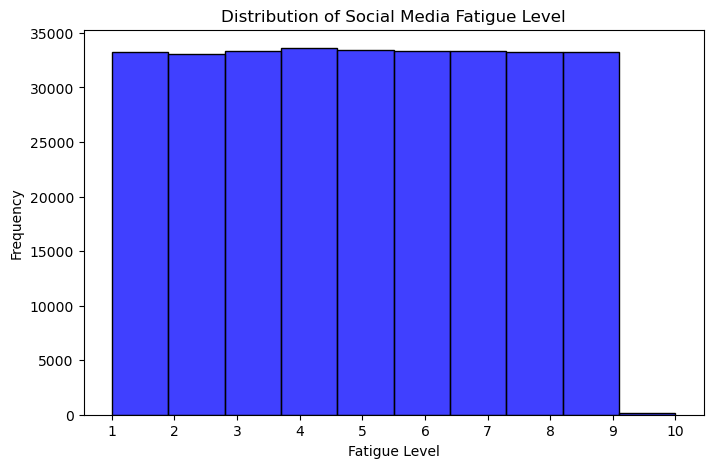

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset again (if not loaded)
final_data = pd.read_csv("Final_Selected_Features.csv")

# Check for and replace infinite values with NaN
final_data.replace([float("inf"), float("-inf")], float("nan"), inplace=True)

# Drop NaN values after replacing infinite values
final_data.dropna(inplace=True)

# Replot the histogram without KDE
plt.figure(figsize=(8, 5))
sns.histplot(final_data["Social Media Fatigue Level (scale 1-10)"], bins=10, kde=False, color="blue")

plt.title("Distribution of Social Media Fatigue Level")
plt.xlabel("Fatigue Level")
plt.ylabel("Frequency")
plt.xticks(range(1, 11))  # Ensure correct x-axis ticks
plt.show()


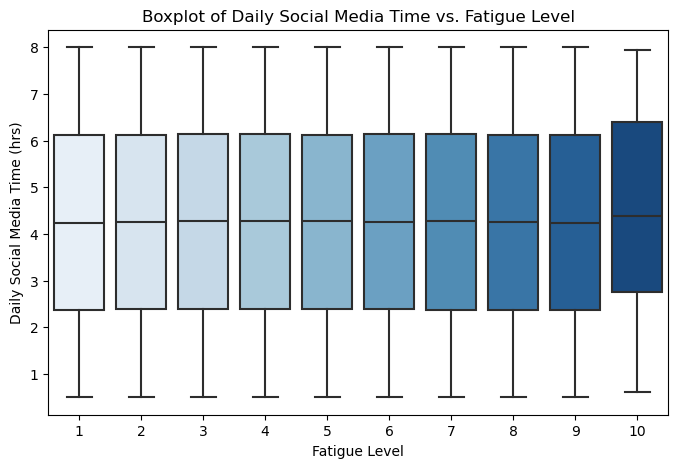

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=final_data["Social Media Fatigue Level (scale 1-10)"], 
            y=final_data["Daily Social Media Time (hrs)"], 
            palette="Blues")
plt.title("Boxplot of Daily Social Media Time vs. Fatigue Level")
plt.xlabel("Fatigue Level")
plt.ylabel("Daily Social Media Time (hrs)")
plt.show()

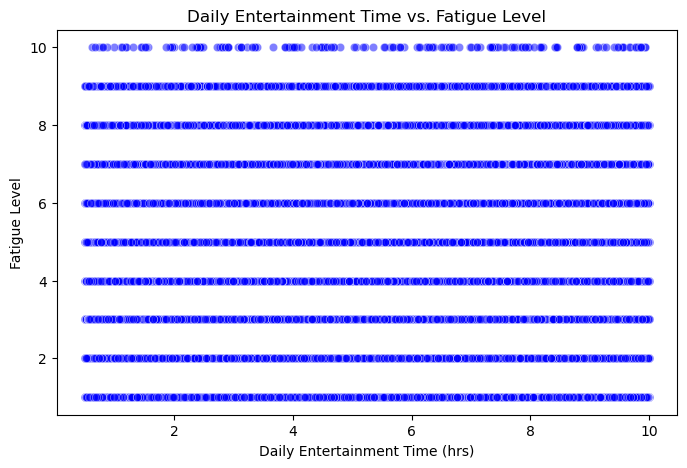

In [33]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=final_data["Daily Entertainment Time (hrs)"], 
                y=final_data["Social Media Fatigue Level (scale 1-10)"], 
                alpha=0.5, color="blue")

plt.title("Daily Entertainment Time vs. Fatigue Level")
plt.xlabel("Daily Entertainment Time (hrs)")
plt.ylabel("Fatigue Level")
plt.show()

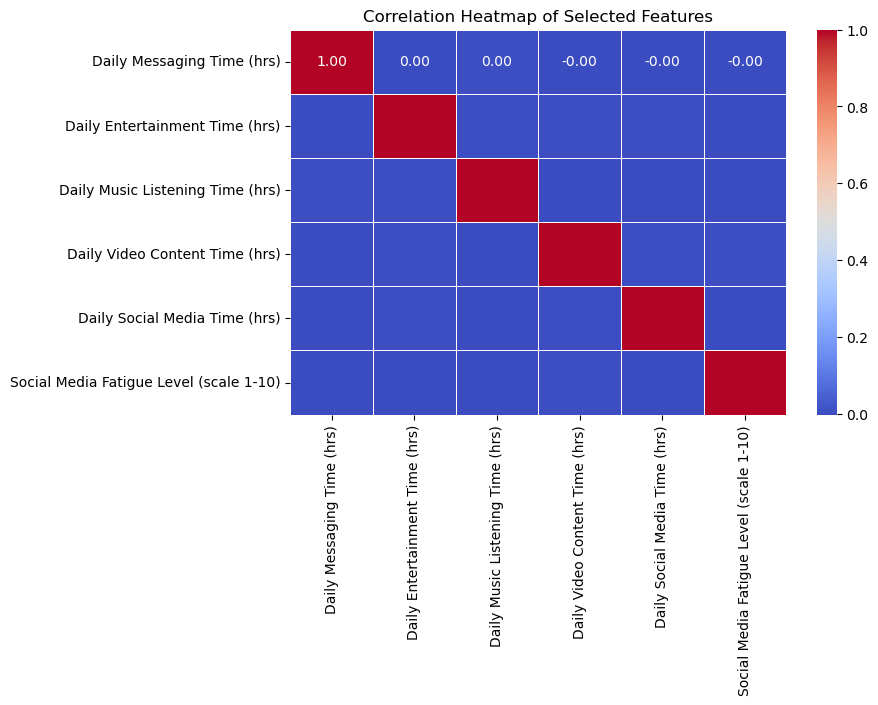

In [35]:
plt.figure(figsize=(8, 5))
sns.heatmap(final_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Selected Features")
plt.show()

### **Conclusion**  

After applying various feature selection techniques, we identified five key features that are most relevant for predicting **Social Media Fatigue Level (scale 1-10)**:  

1. **Daily Messaging Time (hrs)**  
2. **Daily Entertainment Time (hrs)**  
3. **Daily Music Listening Time (hrs)**  
4. **Daily Video Content Time (hrs)**  
5. **Daily Social Media Time (hrs)**  

These features were selected because they directly represent digital consumption habits, which are likely to influence a person's social media fatigue. The selection process involved multiple methods, including **missing value ratio, low variance filter, high correlation filter, Random Forest, backward selection, and forward selection**.  

### **Key Findings**  
- The **histogram** of Social Media Fatigue Levels shows an even distribution across different levels, suggesting no strong skew in the dataset.  
- The **boxplot** indicates that individuals with higher fatigue levels tend to have a slightly wider range of social media usage.  
- The **scatter plot** of daily entertainment time vs. fatigue level suggests that entertainment consumption does not strongly correlate with fatigue.  
- The **heatmap** shows that while these selected features are not highly correlated with each other, they still provide useful predictive power.  

### **Final Thoughts**  
The selected features are practical and easy to interpret, making them useful for building a predictive model. Further analysis, such as testing different machine learning models, could help in understanding how these features interact to predict fatigue more accurately.  